# Valencian Real Estate Market Price Analyis

This notebooks is used to analyze the real estate prices in Valencia. First data is queries via the Idealista API, after that the received data is analyzed.

Questions:

1. What are the average prices in the different districts/neighborhoods of Valencia?
2. What area in Valencia has the best raito rent/sale price?
3. What are the renting prices in the different districts/neighborhoods of Valencia?
4. Are sale prices for flats in the city centre of Valencia rising or falling over time?
5. How long are sale listings publicated before the flat is bought?

Wit that knowledge the following questions can be answered viewing listings:
- Is the price per area of a certain flat good?



## Configure

In [1]:
# API call
import base64
import requests
import json

# standard libs
import re
from pathlib import Path
import json
from datetime import datetime
import getpass
import configparser

# data retrieval
import boto3
from botocore.exceptions import ClientError

# data analysis 
import pandas as pd
pd.set_option('display.max_columns', None)

# data plotting
import seaborn as sns
from matplotlib import pyplot as plt



In [2]:
# initialize config parser
config = configparser.ConfigParser()
config.read('valenciaHousingAnalysis.cfg')

['valenciaHousingAnalysis.cfg']

In [13]:
key = config.get("API","KEY");
secret = config.get('API','SECRET');

## Data Gathering

## Code for AWS Lambda Function

In [6]:
def get_oauth_token(key, secret):
    '''Function creates personalised idealista token from key secret pair.'''
    
    message = key + ":" + secret # Combine the API key and  secret to personalised message
    auth = "Basic " + base64.b64encode(message.encode("ascii")).decode("ascii") # Encode the message   
    headers = {"Authorization" : auth, "Content-Type" : "application/x-www-form-urlencoded;charset=UTF-8"} # Define headers   
    params = {"grant_type" : "client_credentials", "scope" : "read"} # Define request params
    request = requests.post("https://api.idealista.com/oauth/token", headers=headers, params=params)  # Perform the request with the api url, headers and params
    token = json.loads(request.text)['access_token'] # Obtain  personalised token, as a json  

    return token

In [7]:
# function to create search url
def define_request_url(operation):
    '''Function combines search parameters with the url to create search url for request.'''
    
    config = {
       'base_url': 'https://api.idealista.com/3.5/',
       'country': 'es',
       'max_items' : '50',
       'order' : 'distance',
       'center' : '39.4693441,-0.379561',
       'distance' : '1500',
       'property_type' : 'homes',
       'sort' : 'asc',
       'minSize' : '100',
       'maxSize' : '160',
       'elevator' : 'True',
       'airConditioning' : 'True',
       'preservation' : 'good',
       'language': 'en'
       }
    
    url = (config['base_url'] 
           + config['country'] 
           +'/search?operation=' + operation 
           +'&maxItems=' + config['max_items'] 
           + '&order=' + config['order'] 
           + '&center=' + config['center'] 
           + '&distance=' + config['distance'] 
           + '&propertyType=' + config['property_type'] 
           + '&sort=' + config['sort'] 
           + '&minSize=' +config['minSize']
           + '&maxSize=' + config['maxSize']
           + '&numPage=%s' 
           + '&elevator=' + config['elevator'] 
           #+'&airConditioning' + config['airConditioning']
           + '&preservation' + config['preservation'] 
           + '&language=' + config['language'])
    
    return url

In [8]:
# function to request data from idealista API
def query_api(key, secret, url):  
    '''Function uses requests package to query the idealista API with given token and search url.'''
    
    token = get_oauth_token(key, secret) # get the personalised token  
    headers = {'Content-Type': 'Content-Type: multipart/form-data;', # define the search headers  
               'Authorization' : 'Bearer ' + token}

    content = requests.post(url, headers = headers) # return the content from the request  

    if content.text == '': # Transform the result as a json file
        print('Error: Exceeded API call limit or wrong parameters')
        result = None
    else: result = content.text #json.loads(content.text)   

    return result

In [17]:
# request data and loop through all pages

now=datetime.now()
date_time=now.strftime('%Y%m%d_%H%M%S')
    
url = define_request_url('rent') # 'sale'

page = 1
total_pages = 1 # 5

while page <= 1: #total_pages:

    url_of_page = url %(page) # Add the pagination to the url
    
    page_result_json = query_api(key_pau, secret_pau, url_of_page) # Get the search results
    page_result = json.loads(page_result_json)
    total_pages = page_result['totalPages'] # Get amount of pages
    
    filename='listings_' + date_time + '_' + str(page) + '.json'
    
    """
    s3.put_object(
        Bucket=bucket, 
        Key=filename,
        Body=page_result_json
        )
    """
    
    page += 1


In [18]:
total_pages

6

The AWS Lamba function downloads once per week all available listings in a defined area of Valencia.

The following filter are applied when requesting the idealista API:

* 'property_type' : 'homes',
* 'center' : '39.4693441,-0.379561',
* 'distance' : '1500',
* 'minSize' : '100',
* 'maxSize' : '160',
* 'elevator' : 'True',
* 'preservation' : 'good',
* 'order' : 'distance',
* 'sort' : 'asc',
       

![search radius](images/SearchRadius.png "Search Radius")


### Download json files from S3 

After the AWS Lambda function requested data via the idealista API it saved it as JSON files in an S3 bucket. The next step is to download the data from the S3 bucket to be able to analyze it locally.

In [2]:
# Check internet connection
requests.get("https://aws.amazon.com/de/")

<Response [200]>

In [3]:
# AWS Secrets
aws_key_id = getpass.getpass('AWS Access Key ID')
aws_secret = getpass.getpass('AWS Secret')

In [5]:
# configure s3 client

region = 'eu-central-1'
bucket = 'valencialistings'

s3_client = boto3.client('s3',
                        region_name=region,
                        aws_access_key_id=aws_key_id,
                        aws_secret_access_key=aws_secret,
                        ) 

In [11]:
# download all json files

for key in s3_client.list_objects(Bucket=bucket)['Contents']:
    
    # print(key['Key'])
    
    # download csv file written before
    s3_client.download_file(bucket, key['Key'], f"data/s3/{key['Key']}")

### Analyze data

In [36]:
# read one json into dataframe

""" 
with open('./data/s3/listings_20230118_174107_1.json') as json_data:
    data = json.load(json_data)

df = pd.DataFrame(data['elementList'])
df.head()
"""


# read all json into dataframe
df_all_pages = pd.DataFrame()
pathlist = Path('./data/s3/').glob('**/*.json')

for path in pathlist:
     
     path_str = str(path) # because path is object not string
     #print(path_str)
     

     m = re.search('data/s3/listings_([0-9]{8})_([0-9]{6})_([0-9]{1}).json', path_str)
     if m:
          found_1 = m.group(1)
          found_2 = m.group(2)
          found_3 = m.group(3)
     # print(found_1 + ' ' + found_2+ ' ' + found_3)
     
     date_time_obj = datetime.strptime(found_1, '%Y%m%d')

     with open('./' + path_str) as json_data:
          data = json.load(json_data)
          df_page = pd.DataFrame(data['elementList'])
          df_page['dateDownload']= date_time_obj
          df_all_pages = pd.concat([df_all_pages, df_page]) 


In [37]:
# see dataframe with all data         
df_all_pages.head(n=3)

,propertyCode,thumbnail,externalReference,numPhotos,floor,price,propertyType,operation,size,exterior,rooms,bathrooms,address,province,municipality,district,country,neighborhood,latitude,longitude,showAddress,url,distance,description,hasVideo,status,newDevelopment,hasLift,priceByArea,detailedType,suggestedTexts,hasPlan,has3DTour,has360,hasStaging,superTopHighlight,topNewDevelopment,parkingSpace,dateDownload,newDevelopmentFinished,labels
0,98101471,https://img3.idealista.com/blur/WEB_LISTING/0/...,W-02P89I,40,3,500000.0,flat,sale,196.0,True,5,2,barrio El Pilar,València,València,Ciutat Vella,es,El Pilar,39.471032,-0.381730,False,https://www.idealista.com/inmueble/98101471/,596,Luminosa Vivienda Céntrica con Vistas Engel & ...,False,good,False,True,2551.0,{'typology': 'flat'},"{'subtitle': 'El Pilar, València', 'title': 'P...",True,True,False,False,False,False,NaN,2023-02-19,NaN,NaN
1,98304152,https://img3.idealista.com/blur/WEB_LISTING/0/...,W-02OF2X,36,2,395000.0,flat,sale,142.0,True,3,2,barrio Arrancapins,València,València,Extramurs,es,Arrancapins,39.465840,-0.387133,False,https://www.idealista.com/inmueble/98304152/,1255,Vivienda reformada en Arracapins Engel & Völke...,False,good,False,True,2782.0,{'typology': 'flat'},"{'subtitle': 'Arrancapins, València', 'title':...",True,False,False,False,False,False,NaN,2023-02-19,NaN,NaN
2,100344074,https://img3.idealista.com/blur/WEB_LISTING/0/...,VV2302002,22,2,545000.0,flat,sale,200.0,True,5,3,Calle de Gregori Mayans,València,València,L'Eixample,es,Gran Vía,39.463490,-0.370113,False,https://www.idealista.com/inmueble/100344074/,1035,Piso en venta de 5 habitaciones en Gran Vía. L...,False,good,False,True,2725.0,{'typology': 'flat'},"{'subtitle': 'Gran Vía, València', 'title': 'P...",False,False,False,False,False,False,"{'hasParkingSpace': True, 'isParkingSpaceInclu...",2023-02-19,NaN,NaN


In [82]:
df_all_pages.count()

propertyCode              7926
thumbnail                 7882
externalReference         6573
numPhotos                 7926
floor                     7654
price                     7926
propertyType              7926
operation                 7926
size                      7926
exterior                  7926
rooms                     7926
bathrooms                 7926
address                   7926
province                  7926
municipality              7926
district                  7926
country                   7926
neighborhood              7926
latitude                  7926
longitude                 7926
showAddress               7926
url                       7926
distance                  7926
description               7911
hasVideo                  7926
status                    7926
newDevelopment            7926
hasLift                   7926
priceByArea               7926
detailedType              7926
suggestedTexts            7926
hasPlan                   7926
has3DTou

How many listings are downloaded every week?
The idealista API allows 100 requests per month, with 50 listings per request. In total this results into a maximum of 5000 listings per month.

In [76]:
df_download_date = \
    df_all_pages \
        .groupby(by=['dateDownload']) \
        .agg({'propertyCode': ['count']}) \
        .reset_index() \

df_download_date.head(n=15)

,dateDownload,propertyCode
,,count
0,2023-01-22,500
1,2023-01-29,1036
2,2023-02-05,800
3,2023-02-12,600
4,2023-02-19,576
5,2023-02-26,587
6,2023-03-05,768
7,2023-03-12,850
8,2023-03-19,759


Let's get an overview of the mean price per area by neighborhood over all real estate listings:


In [77]:
# Statistics per neigbourhood including all non-duplicates
    #.drop_duplicates(subset=['floor', 'size', 'rooms', 'bathrooms', 'neighborhood', 'price'], keep='last')
df_neighborhoods = \
    df_all_pages \
        .groupby(by=['district', 'neighborhood']) \
        .agg({'propertyCode': ['count'],
              'priceByArea': ['mean'], 
              'size': ['mean'], 
              'price': ['mean']
              }) \
        .reset_index() \

df_neighborhoods.columns = ['district', 'neighborhood', 'count_listings', 'mean_priceByArea', 'mean_size', 'mean_prize']
df_neighborhoods.sort_values(['mean_priceByArea'], ascending = [False]) \
    .head(n=60)

,district,neighborhood,count_listings,mean_priceByArea,mean_size,mean_prize
15,L'Eixample,El Pla del Remei,757,3744.801849,142.955086,516833.553501
21,La Saïdia,Trinitat,162,3184.858025,144.962963,454218.518519
3,Ciutat Vella,La Seu,127,3117.834646,148.921260,454472.401575
9,El Pla del Real,Mestalla,12,3062.000000,184.583333,567166.666667
16,L'Eixample,Gran Vía,669,3050.529148,155.343797,468909.992526
4,Ciutat Vella,La Xerea,502,2963.509960,155.641434,456651.372510
8,El Pla del Real,Jaume Roig,36,2959.500000,192.638889,551388.888889
7,El Pla del Real,Exposició,248,2943.217742,164.092742,478931.451613
17,L'Eixample,Russafa,762,2830.723097,152.371391,425559.971129
0,Ciutat Vella,El Carme,329,2821.759878,158.522796,425000.595745


Now the same aggregations, but only for flats that are similar to the one we are looking for:

In [78]:
# Statistics per district of non-duplicates with required specifics
    # .drop_duplicates(subset=['floor', 'size', 'rooms', 'bathrooms', 'neighborhood', 'price'], keep='last') \
df_districts = \
    df_all_pages[(df_all_pages.hasLift == True)
                 & (df_all_pages.floor != '1')
                 & (df_all_pages.size > 120)
                 & (df_all_pages.rooms >= 2)
                 & (df_all_pages.bathrooms >= 2)] \
        .groupby(by=['district', 'neighborhood']) \
        .agg({'propertyCode': ['count'],
              'priceByArea': ['mean'], 
              'size': ['mean'], 
              'price': ['mean']
              }) \
        .reset_index() \

df_districts.columns = ['district', 'neighborhood', 'count_listings', 'mean_priceByArea', 'mean_size', 'mean_prize']
df_districts.sort_values(['mean_priceByArea'], ascending = [False]) \
    .head(n=60)
    


,district,neighborhood,count_listings,mean_priceByArea,mean_size,mean_prize
13,L'Eixample,El Pla del Remei,470,3650.938298,145.429787,513148.936170
19,La Saïdia,Trinitat,152,3265.835526,144.565789,464693.421053
3,Ciutat Vella,La Seu,105,3216.066667,149.742857,470076.142857
7,El Pla del Real,Jaume Roig,25,3204.120000,168.720000,532800.000000
14,L'Eixample,Gran Vía,518,3185.538610,156.679537,492457.133205
4,Ciutat Vella,La Xerea,351,3077.122507,152.202279,462621.051282
8,El Pla del Real,Mestalla,12,3062.000000,184.583333,567166.666667
6,El Pla del Real,Exposició,230,2976.173913,164.343478,484586.956522
15,L'Eixample,Russafa,618,2898.268608,154.313916,440523.783172
0,Ciutat Vella,El Carme,196,2797.301020,146.479592,396684.673469


In [79]:
# Statistics of non-duplicates over time
    # .drop_duplicates(subset=['floor', 'size', 'rooms', 'bathrooms', 'neighborhood', 'price'], keep='last') \
df_city_prices_time_series = \
    df_all_pages \
        .groupby(by=['dateDownload']) \
        .agg({'propertyCode': ['count'],
              'priceByArea': ['mean'], 
              'size': ['mean'], 
              'price': ['mean']
              }) \
        .reset_index() \

df_city_prices_time_series.columns = ['dateDownload', 'count_listings', 'mean_priceByArea', 'mean_size', 'mean_prize']
df_city_prices_time_series \
    .sort_values(['dateDownload']) \
    .head(n=60)

,dateDownload,count_listings,mean_priceByArea,mean_size,mean_prize
0,2023-01-22,500,2823.952000,160.278000,439842.952000
1,2023-01-29,1036,2813.136100,159.516409,435618.302124
2,2023-02-05,800,2832.100000,160.181250,440098.712500
3,2023-02-12,600,2846.010000,157.643333,435762.973333
4,2023-02-19,576,2810.843750,157.814236,431996.324653
5,2023-02-26,587,2824.930153,160.647359,441184.473595
6,2023-03-05,768,2819.765625,158.236979,434492.545573
7,2023-03-12,850,2838.730588,160.214118,441510.914118
8,2023-03-19,759,2822.050066,160.824769,440047.274045
9,2023-03-26,594,2851.501684,161.410774,446692.080808


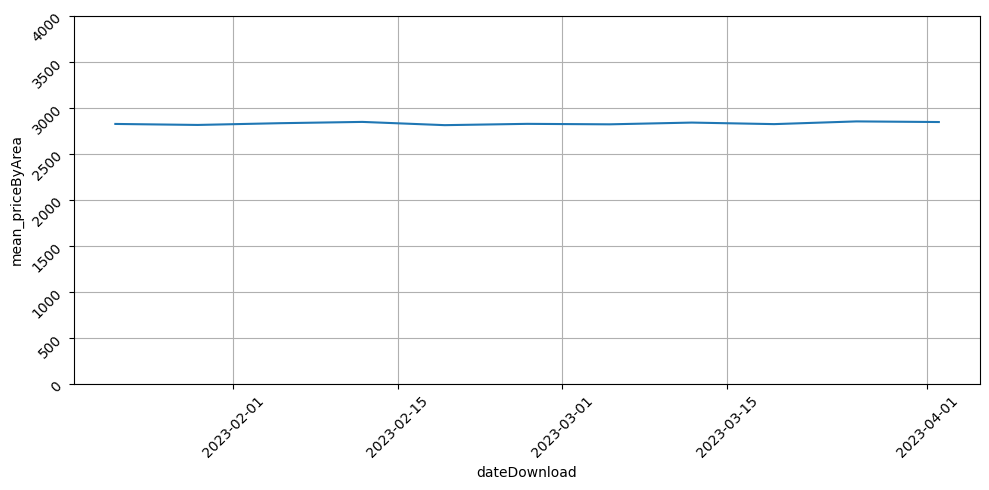

In [91]:
# plot time series of mean price by area in Valencia
plt.rcParams["figure.figsize"] = [10.00, 5.00]
plt.rcParams["figure.autolayout"] = True

ax = sns.lineplot(data=df_city_prices_time_series, x="dateDownload", y="mean_priceByArea")
ax.set_ylim(0, 4000)
ax.tick_params(rotation=45)

plt.grid()
plt.show()

In [88]:

# Statistics per district including all non-duplicates
    # .drop_duplicates(subset=['floor', 'size', 'rooms', 'bathrooms', 'neighborhood', 'price'], keep='last')
df_districts_prices_time_series  = \
    df_all_pages \
        .groupby(by=['district', 'dateDownload']) \
        .agg({'propertyCode': ['count'],
              'priceByArea': ['mean'], 
              'size': ['mean'], 
              'price': ['mean']
              }) \
        .reset_index() \
            


df_districts_prices_time_series.columns = ['district', 'dateDownload', 'count_listings', 'mean_priceByArea', 'mean_size', 'mean_prize']

df_districts_prices_time_series = df_districts_prices_time_series[df_districts_prices_time_series.count_listings > 50]

df_districts_prices_time_series \
    .sort_values(['district', 'dateDownload']) \
    .head(n=60)

,district,dateDownload,count_listings,mean_priceByArea,mean_size,mean_prize
0,Ciutat Vella,2023-01-22,188,2741.494681,173.186170,457229.191489
1,Ciutat Vella,2023-01-29,364,2735.412088,173.156593,456723.568681
2,Ciutat Vella,2023-02-05,284,2778.327465,169.623239,456015.084507
3,Ciutat Vella,2023-02-12,225,2780.168889,165.240000,444939.982222
4,Ciutat Vella,2023-02-19,222,2782.085586,168.337838,453441.878378
5,Ciutat Vella,2023-02-26,226,2762.659292,173.146018,462338.491150
6,Ciutat Vella,2023-03-05,302,2774.221854,169.003311,454149.970199
7,Ciutat Vella,2023-03-12,311,2779.858521,171.045016,460651.739550
8,Ciutat Vella,2023-03-19,285,2747.828070,170.210526,453378.582456
9,Ciutat Vella,2023-03-26,204,2788.220588,173.955882,468211.264706


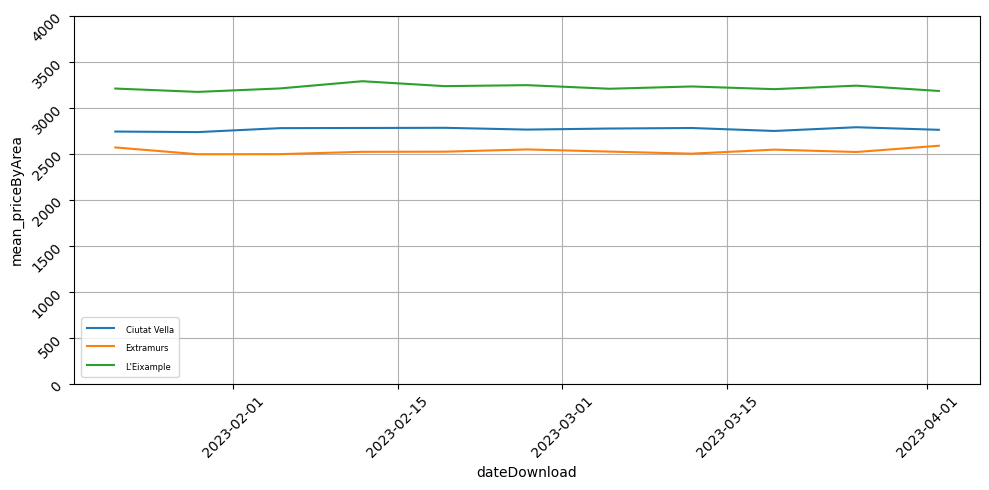

In [90]:
plt.rcParams["figure.figsize"] = [10.00, 5.00]
plt.rcParams["figure.autolayout"] = True


ax = sns.lineplot(data=df_districts_prices_time_series, x='dateDownload', y='mean_priceByArea', hue='district')

ax.set_ylim(0, 4000)
ax.tick_params(rotation=45)
plt.legend(loc='lower left')

plt.setp(ax.get_legend().get_texts(), fontsize='6') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='10') # for legend title

plt.grid()
plt.show()

In [ ]:
# propertyCode


## TODO

* statistics:
  * how long is a property online
  * how are single property prices behaving over time
* renting
  * with second account request renting prices
  * compare renting prices to house prices
  * calculate years for ROI